In [7]:
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)


## Carga de Datos

In [8]:
main_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
main_dir

'/home/diego/got-rag-chatbot'

In [9]:
# Ruta al archivo de resultados generado por el Juez

RESULTS_PATH = os.path.join(main_dir, 'data', 'eval', 'evaluation_results_6.jsonl')

def load_results(path):
    if not os.path.exists(path):
        print(f"❌ No se encontró el archivo: {path}")
        return pd.DataFrame()
    
    # Leemos línea por línea para evitar errores de parseo masivo
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

df = load_results(RESULTS_PATH)

print(f"✅ Datos cargados: {len(df)} evaluaciones.")
df.head(2)

✅ Datos cargados: 116 evaluaciones.


,id,question,prediction,ground_truth,score,reason,type,evidence_source
0,gen_0,Which House is House Kenning a vassal of?,House Kenning is a vassal of House Harlaw.,House Harlaw,1,"The prediction accurately states that House Kenning is a vassal of House Harlaw, which matches the ground truth.",Unknown,Graph
1,gen_1,What religion does House Kenning follow?,House Kenning follows the Drowned God.,Drowned God,1,"The prediction accurately states that House Kenning follows the Drowned God, which directly matches the ground truth.",Unknown,Graph


## Métricas Globales (KPIs)

In [10]:
if not df.empty:
    accuracy = df['score'].mean() * 100
    total = len(df)
    correct = df['score'].sum()
    failed = total - correct

    print("="*40)
    print(f"📊 REPORTE DE DESEMPEÑO GENERAL")
    print("="*40)
    print(f"🎯 Precisión Global (Accuracy):  {accuracy:.2f}%")
    print(f"✅ Respuestas Correctas:        {correct}")
    print(f"❌ Fallos (Score 0):            {failed}")
    print("="*40)
else:
    print("⚠️ El dataframe está vacío.")

📊 REPORTE DE DESEMPEÑO GENERAL
🎯 Precisión Global (Accuracy):  76.72%
✅ Respuestas Correctas:        89
❌ Fallos (Score 0):            27


## Análisis por Fuente de Evidencia (Grafo vs Texto)

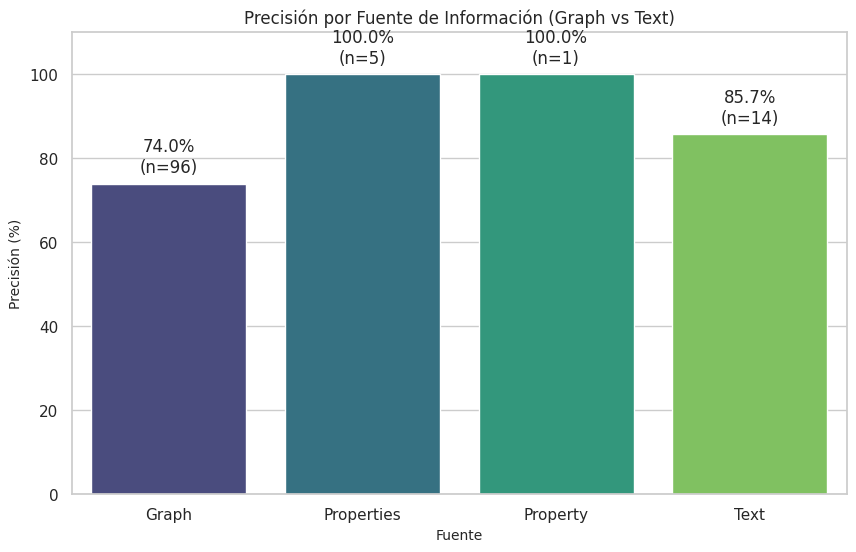

In [11]:
if not df.empty and 'evidence_source' in df.columns:
    # Crear la figura y los ejes explícitamente
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calcular datos
    source_metrics = df.groupby('evidence_source')['score'].mean() * 100
    source_counts = df['evidence_source'].value_counts()
    
    sns.barplot(
        x=source_metrics.index, 
        y=source_metrics.values, 
        hue=source_metrics.index,  
        legend=False,              
        palette="viridis", 
        ax=ax
    )
    
    ax.set_title('Precisión por Fuente de Información (Graph vs Text)', fontsize=12)
    ax.set_ylabel('Precisión (%)', fontsize=10)
    ax.set_xlabel('Fuente', fontsize=10)
    ax.set_ylim(0, 110)
    
    # Etiquetas de datos
    for i, p in enumerate(ax.patches):
        if i < len(source_metrics.index):
            col_name = source_metrics.index[i]
            count = source_counts.get(col_name, 0)
            height = p.get_height()
            ax.annotate(f'{height:.1f}%\n(n={count})', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', xytext=(0, 5), 
                        textcoords='offset points')

    plt.show()
else:
    print("⚠️ No hay datos suficientes o falta la columna 'evidence_source'.")

## Auditoría de Fallos

In [12]:
# Filtramos solo los errores
df_failures = df[df['score'] == 0].copy()

print(f"🔍 Analizando {len(df_failures)} fallos encontrados:")

# Mostramos columnas clave
display_cols = ['question', 'prediction', 'ground_truth', 'reason', 'evidence_source']
# Asegúrate de que las columnas existan
cols = [c for c in display_cols if c in df_failures.columns]

# Mostrar tabla interactiva (pandas styler)
df_failures[cols].style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])

🔍 Analizando 27 fallos encontrados:


,question,prediction,ground_truth,reason,evidence_source
9,Who was a child of Aenar Targaryen?,The archives are silent on this.,Daenys Targaryen,"The prediction states it does not know the answer, which directly contradicts the ground truth that provides the correct answer.",Graph
12,Which specific Houses are identified as vassals of House Stark in the graph connections?,"The specific Houses identified as vassals of House Stark in the graph connections are: House Cassel, House Dustin, House Bolton, House Manderly, House Hornwood, House Arryn, House Mazin, House Cerwyn, House Baelish, House Tully, House Tallhart, House Umber, House Flint, House Glover, House Reed, House Mormont, House Karstark, House Poole, House Dormand, and House Seaworth.","['House Karstark --[VASSAL_OF]--> (This Node)', 'House Mormont --[VASSAL_OF]--> (This Node)']","The prediction includes many incorrect houses as vassals of House Stark (e.g., House Cassel, House Dustin, House Bolton, House Arryn, House Tully) in addition to the correct ones. According to the rules, if the prediction retrieves wrong info or extra wrong entities, the score is 0.",Graph
13,Who is listed as the current Head of House Stark?,The archives list Queen Sansa Stark and Lord Cregan Stark as the current Heads of House Stark.,Queen Sansa Stark,"The prediction includes an extra, incorrect entity ('Lord Cregan Stark') in addition to the correct one. The rules state that if the prediction retrieves wrong info or extra wrong entities, the score is 0.",Text
14,What religion does Wineiri Baratheon follow?,Wineiri Baratheon follows the Faith of the Seven.,Faith of the Seven,"While the prediction contains 'Faith of the Seven' which is the semantic meaning of the ground truth, the character 'Wineiri Baratheon' does not exist in the Game of Thrones universe. By stating 'Wineiri Baratheon follows the Faith of the Seven,' the prediction provides wrong information by attributing a characteristic to a non-existent entity, which falls under the rule 'If the prediction retrieves wrong info or extra wrong entities, Score is 0.'",Graph
15,Who is a parent of Wineiri Baratheon?,William Baratheon and Martyna Mullendore are parents of Wineiri Baratheon.,William Baratheon,"The prediction includes 'Martyna Mullendore' as a parent, which is an extra entity not present in the ground truth. As per the rules, if the prediction retrieves wrong info or extra wrong entities, the score is 0. The ground truth only validates William Baratheon.",Graph
16,Who is a sibling of Lorax Baratheon?,"The siblings of Lorax Baratheon are Theodor Baratheon, Bryte Baratheon, Lex Baratheon, Gude Baratheon, Miriam Baratheon, William Baratheon (son of William), Jon Baratheon, Brune Baratheon, Tommax Baratheon, Orys Baratheon (son of William), Martyn Baratheon, and Mace Baratheon.",Miriam Baratheon,"The prediction includes the correct sibling, Miriam Baratheon, but also lists many other names (Theodor, Bryte, Lex, Gude, William, Jon, Brune, Tommax, Orys, Martyn, and Mace Baratheon) that are extra wrong entities, making the score 0 according to the rules.",Graph
24,Which individuals are explicitly affiliated with the Alchemists Guild according to the provided data?,"According to the Great Ledger (Verified Facts from Graph), the provided data includes individuals named Rossart and Hallyne, but it does not explicitly state their affiliation with the Alchemists Guild.",Rossart and Hallyne,"The prediction correctly identifies the individuals but incorrectly states that their affiliation with the Alchemists Guild is not explicitly mentioned, which contradicts the Ground Truth that implies their affiliation is known.",Graph
26,Which individuals are members of House Florent?,The following individuals are members of House Florent: * Alyrie Florent * Axell Florent * Rylene Florent * Imry Florent,"Alyrie Florent, Rylene Florent, Axell Florent, Selyse Baratheon, Imry Florent, Melessa Tarly","The prediction is incomplete as it misses Selyse Baratheo